In [1]:
import pandas as pd
import numpy as np
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

# Load dataset
file_path = "Bass_Diffusion_Cleaned_Final.xlsx"  # Path to your Excel file
df = pd.read_excel(file_path)

# Define Starbucks market share for past years
market_share_data = {
    2018: 0.38,
    2019: 0.34,
    2020: 0.31,
    2021: 0.28,
    2022: 0.21,
    2023: 0.19
}

# Assign past market share data
df["Market_Share (%)"] = df["Year"].map(market_share_data)

# Select features including Market Share
features = [
    "Total_Stores", "New_Stores", "log(GDP_Per_Capita)",
    "Urbanization_Rate (%)", "College_degree_or_above (%)",
    "15-65_Population_Share (%)", "Market_Share (%)", "log(Foreign-funded_enterprises)", "log(VAT)", "log(Freight_volume (ten thousand tons))",
    "log(Express (in ten thousand pieces))", "log(Domain_names (in ten thousand))"
]

# Corrected Calculation of Market Potential (M)
df["M"] = df["Total_Stores"] / df["Market_Share (%)"]

# Drop NaN values
df = df.dropna()

# Get the **latest available data** for each area
latest_df = df.sort_values(by="Year").groupby("Area").last().reset_index()

# Prepare training data
X = latest_df[features]
y = latest_df["M"]

# Use MinMaxScaler instead of StandardScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split train-test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define Optuna objective function for Random Forest
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 10, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
    }

    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error").mean()
    return -score  # Minimize MAE

# Optimize parameters with Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Get best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train optimized Random Forest model
rf_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict potential market size (M) for all areas
latest_df["M_Predicted"] = rf_model.predict(X_scaled)

# Save to CSV
output_file = "Estimated_M.csv"
latest_df[["Area", "M_Predicted"]].sort_values(by=["Area"]).to_csv(output_file, index=False)

print(f"Predictions saved to {output_file}")

[I 2025-03-19 22:05:32,451] A new study created in memory with name: no-name-97a7a038-75ee-43c1-a2b2-ded98f3fb8dc
[I 2025-03-19 22:05:33,036] Trial 0 finished with value: 733.8998059242191 and parameters: {'n_estimators': 293, 'max_depth': 29, 'min_samples_split': 12, 'min_samples_leaf': 6}. Best is trial 0 with value: 733.8998059242191.
[I 2025-03-19 22:05:33,592] Trial 1 finished with value: 998.6308945688512 and parameters: {'n_estimators': 261, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 733.8998059242191.
[I 2025-03-19 22:05:33,983] Trial 2 finished with value: 1004.7673831480766 and parameters: {'n_estimators': 158, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 733.8998059242191.
[I 2025-03-19 22:05:34,560] Trial 3 finished with value: 679.3385606220387 and parameters: {'n_estimators': 280, 'max_depth': 33, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 3 with value: 6

Best Parameters: {'n_estimators': 277, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1}
Predictions saved to Estimated_M.csv


In [34]:
# Compute R¬≤ score
from sklearn.metrics import r2_score
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R¬≤ Score: {r2:.4f}")

R¬≤ Score: 0.7896


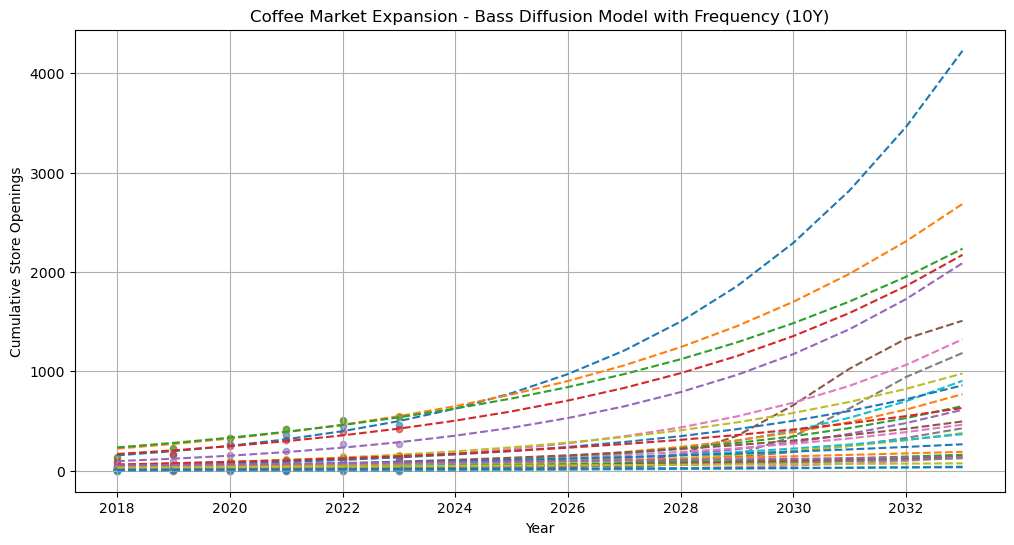

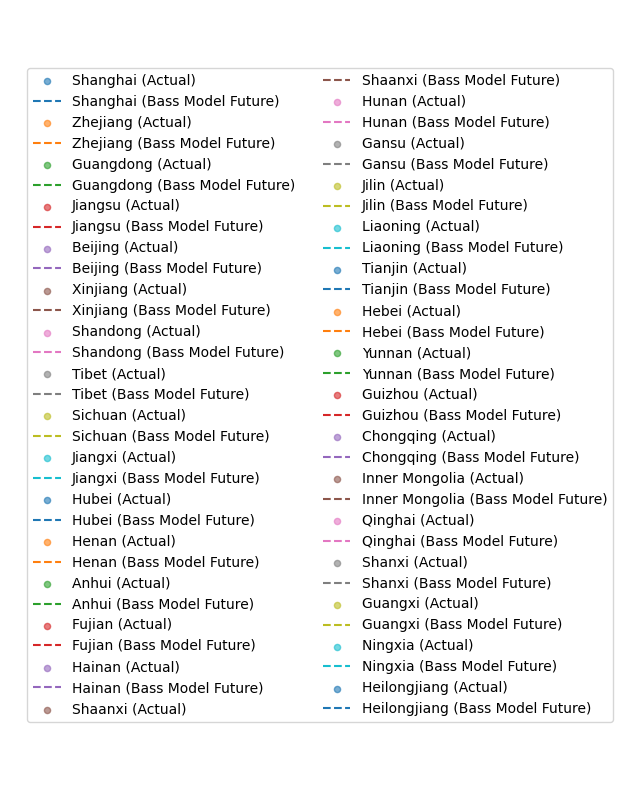

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from xgboost import XGBRegressor

# ËÆ°ÁÆóË¥≠‰π∞È¢ëÁéá F
def calculate_F():
    probabilities = [0.016, 0.10, 0.079, 0.156, 0.434, 0.215]
    consumption = [0, 2, 2.5, 4, 10, 30]
    return sum(p * c for p, c in zip(probabilities, consumption))

F_value = calculate_F()

# ‰øÆÊîπ Bass Diffusion ModelÔºåÂä†ÂÖ• F
def bass_model_with_F(t, p, q, M, F):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p+q) * t)) * F

# ËØªÂèñÂ∏ÇÂú∫ÊΩúÂäõÊï∞ÊçÆ
file_path = "Estimated_M.csv"
df = pd.read_csv(file_path)
area_m_values = dict(zip(df["Area"], df["M_Predicted"]))

# ËØªÂèñÊï∞ÊçÆ
df = pd.read_excel("Bass_Diffusion_Cleaned_Final.xlsx")

# ËÆæÁΩÆÂèÇÊï∞
target = "New_Stores"
future_years = 10
past_years = 10
results = []

# ÈÅçÂéÜÊâÄÊúâÂå∫Âüü
for area in df["Area"].unique():
    area_data = df[df["Area"] == area].sort_values(by="Year", ascending=True)
    
    if len(area_data) < 3:
        print(f"Skipping {area} due to insufficient data points (< 3)")
        continue

    years = area_data["Year"].values
    y = area_data[target].values
    adopters = np.cumsum(y)

    # ËØªÂèñ `M`
    market_size = area_m_values.get(area, 2500)

    # ËÆ≠ÁªÉ XGBoost È¢ÑÊµãËøáÂéª 10 Âπ¥Êï∞ÊçÆ
    past_years_range = np.arange(years.min() - past_years, years.min())
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    xgb_model.fit(years.reshape(-1, 1), adopters)
    past_predictions = xgb_model.predict(past_years_range.reshape(-1, 1))

    # ÂêàÂπ∂ÂéÜÂè≤Êï∞ÊçÆ
    all_years = np.concatenate([past_years_range, years])
    all_adopters = np.concatenate([past_predictions, adopters])

    # ÊãüÂêà Bass Ê®°Âûã
    try:
        popt, _ = curve_fit(lambda t, p, q: bass_model_with_F(t, p, q, market_size, F_value),
                            xdata=(all_years - all_years.min()),
                            ydata=all_adopters,
                            p0=(0.01, 0.3),
                            bounds=(0, [1, 0.9]))
        p_base, q_base = popt
    except RuntimeError:
        print(f"Warning: Could not fit Bass model for {area}")
        continue

    # È¢ÑÊµãÊú™Êù• 10 Âπ¥
    future_years_range = np.arange(years.min(), years.max() + future_years + 1)
    future_predictions = bass_model_with_F(future_years_range - all_years.min(), p_base, q_base, market_size, F_value)

    # Â≠òÂÇ®ÁªìÊûú
    final_adoption = future_predictions[-1]
    results.append((area, past_years_range, past_predictions, future_years_range, future_predictions, years, adopters, final_adoption))

# ÊåâÊúÄÁªàÂ∏ÇÂú∫ËßÑÊ®°ÊéíÂ∫è
results.sort(key=lambda x: x[-1], reverse=True)

# ÁîªÂõæ
fig, ax = plt.subplots(figsize=(12, 6))
handles = []
labels = []

for area, past_years_range, past_predictions, future_years_range, future_predictions, years, adopters, final_adoption in results:
    scatter = ax.scatter(years, adopters, alpha=0.6, s=20)
    handles.append(scatter)
    labels.append(f"{area} (Actual)")
    
    line, = ax.plot(future_years_range, future_predictions, linestyle="--")
    handles.append(line)
    labels.append(f"{area} (Bass Model Future)")

plt.xlabel("Year")
plt.ylabel("Cumulative Store Openings")
plt.title("Coffee Market Expansion - Bass Diffusion Model with Frequency (10Y)")
plt.grid(True)

# Create legend
fig_legend, ax_legend = plt.subplots(figsize=(8, 10))  # Adjust legend size
ax_legend.axis("off")  # Remove axes
legend = ax_legend.legend(handles, labels, loc="center", fontsize=10, ncol=2)  # Center legend, 2 columns
fig_legend.canvas.draw()

plt.show()

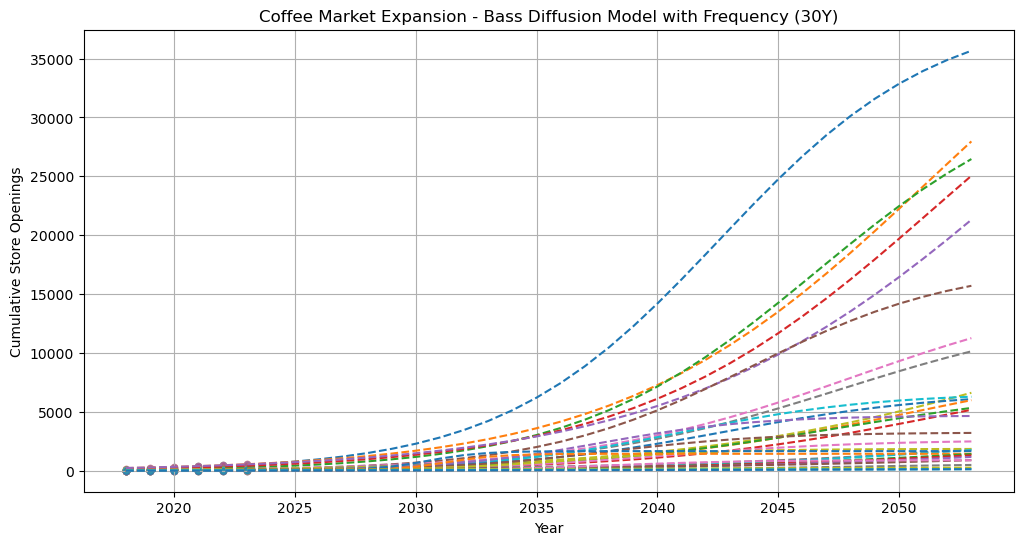

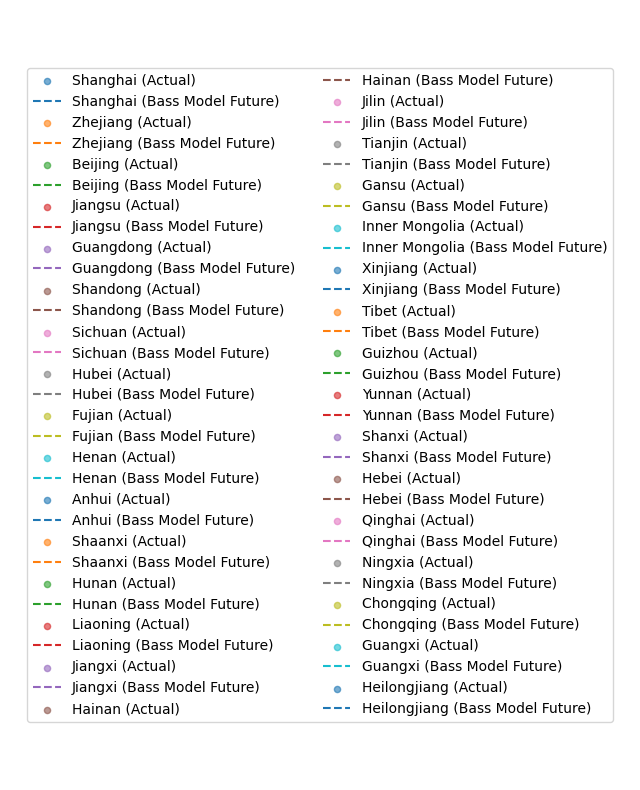

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from xgboost import XGBRegressor

# ËÆ°ÁÆóË¥≠‰π∞È¢ëÁéá F
def calculate_F():
    probabilities = [0.016, 0.10, 0.079, 0.156, 0.434, 0.215]
    consumption = [0, 2, 2.5, 4, 10, 30]
    return sum(p * c for p, c in zip(probabilities, consumption))

F_value = calculate_F()

# ‰øÆÊîπ Bass Diffusion ModelÔºåÂä†ÂÖ• F
def bass_model_with_F(t, p, q, M, F):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p+q) * t)) * F

# ËØªÂèñÂ∏ÇÂú∫ÊΩúÂäõÊï∞ÊçÆ
file_path = "Estimated_M.csv"
df = pd.read_csv(file_path)
area_m_values = dict(zip(df["Area"], df["M_Predicted"]))

# ËØªÂèñÊï∞ÊçÆ
df = pd.read_excel("Bass_Diffusion_Cleaned_Final.xlsx")

# ËÆæÁΩÆÂèÇÊï∞
target = "New_Stores"
future_years = 30
past_years = 10
results = []

# ÈÅçÂéÜÊâÄÊúâÂå∫Âüü
for area in df["Area"].unique():
    area_data = df[df["Area"] == area].sort_values(by="Year", ascending=True)
    
    if len(area_data) < 3:
        print(f"Skipping {area} due to insufficient data points (< 3)")
        continue

    years = area_data["Year"].values
    y = area_data[target].values
    adopters = np.cumsum(y)

    # ËØªÂèñ `M`
    market_size = area_m_values.get(area, 2500)

    # ËÆ≠ÁªÉ XGBoost È¢ÑÊµãËøáÂéª 10 Âπ¥Êï∞ÊçÆ
    past_years_range = np.arange(years.min() - past_years, years.min())
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    xgb_model.fit(years.reshape(-1, 1), adopters)
    past_predictions = xgb_model.predict(past_years_range.reshape(-1, 1))

    # ÂêàÂπ∂ÂéÜÂè≤Êï∞ÊçÆ
    all_years = np.concatenate([past_years_range, years])
    all_adopters = np.concatenate([past_predictions, adopters])

    # ÊãüÂêà Bass Ê®°Âûã
    try:
        popt, _ = curve_fit(lambda t, p, q: bass_model_with_F(t, p, q, market_size, F_value),
                            xdata=(all_years - all_years.min()),
                            ydata=all_adopters,
                            p0=(0.01, 0.3),
                            bounds=(0, [1, 0.9]))
        p_base, q_base = popt
    except RuntimeError:
        print(f"Warning: Could not fit Bass model for {area}")
        continue

    # È¢ÑÊµãÊú™Êù• 10 Âπ¥
    future_years_range = np.arange(years.min(), years.max() + future_years + 1)
    future_predictions = bass_model_with_F(future_years_range - all_years.min(), p_base, q_base, market_size, F_value)

    # Â≠òÂÇ®ÁªìÊûú
    final_adoption = future_predictions[-1]
    results.append((area, past_years_range, past_predictions, future_years_range, future_predictions, years, adopters, final_adoption))

# ÊåâÊúÄÁªàÂ∏ÇÂú∫ËßÑÊ®°ÊéíÂ∫è
results.sort(key=lambda x: x[-1], reverse=True)

# ÁîªÂõæ
fig, ax = plt.subplots(figsize=(12, 6))
handles = []
labels = []

for area, past_years_range, past_predictions, future_years_range, future_predictions, years, adopters, final_adoption in results:
    scatter = ax.scatter(years, adopters, alpha=0.6, s=20)
    handles.append(scatter)
    labels.append(f"{area} (Actual)")
    
    line, = ax.plot(future_years_range, future_predictions, linestyle="--")
    handles.append(line)
    labels.append(f"{area} (Bass Model Future)")

plt.xlabel("Year")
plt.ylabel("Cumulative Store Openings")
plt.title("Coffee Market Expansion - Bass Diffusion Model with Frequency (30Y)")
plt.grid(True)

# Create legend
fig_legend, ax_legend = plt.subplots(figsize=(8, 10))  # Adjust legend size
ax_legend.axis("off")  # Remove axes
legend = ax_legend.legend(handles, labels, loc="center", fontsize=10, ncol=2)  # Center legend, 2 columns
fig_legend.canvas.draw()

plt.show()

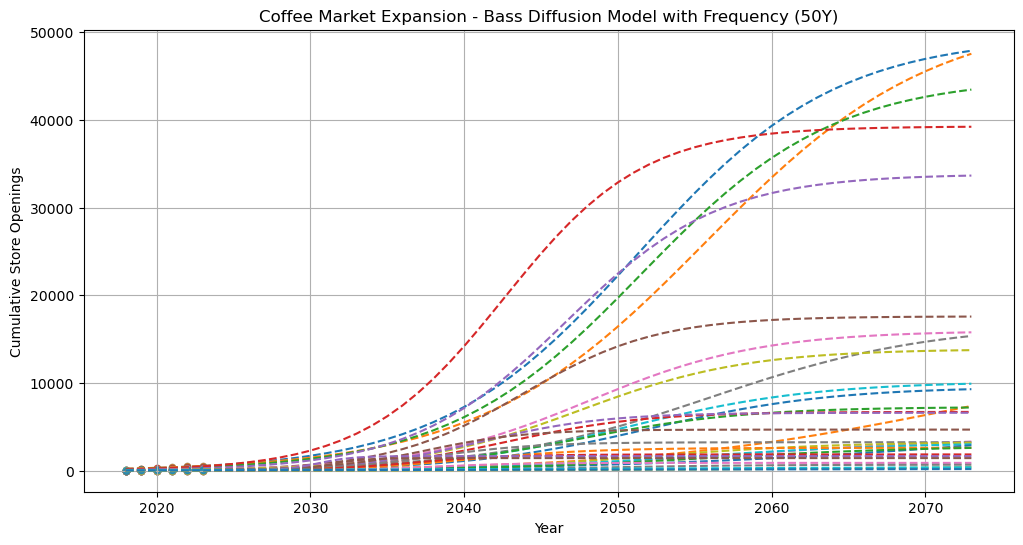

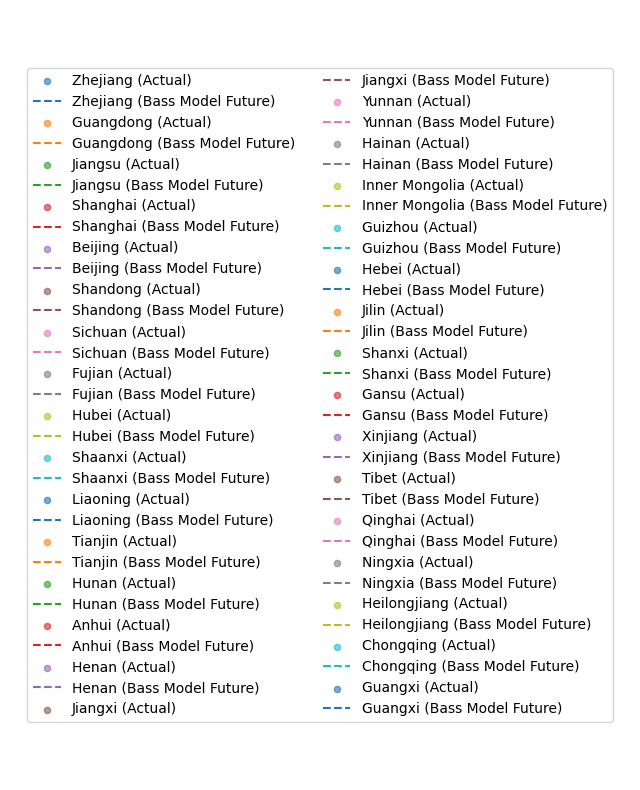

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from xgboost import XGBRegressor

# ËÆ°ÁÆóË¥≠‰π∞È¢ëÁéá F
def calculate_F():
    probabilities = [0.016, 0.10, 0.079, 0.156, 0.434, 0.215]
    consumption = [0, 2, 2.5, 4, 10, 30]
    return sum(p * c for p, c in zip(probabilities, consumption))

F_value = calculate_F()

# ‰øÆÊîπ Bass Diffusion ModelÔºåÂä†ÂÖ• F
def bass_model_with_F(t, p, q, M, F):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p+q) * t)) * F

# ËØªÂèñÂ∏ÇÂú∫ÊΩúÂäõÊï∞ÊçÆ
file_path = "Estimated_M.csv"
df = pd.read_csv(file_path)
area_m_values = dict(zip(df["Area"], df["M_Predicted"]))

# ËØªÂèñÊï∞ÊçÆ
df = pd.read_excel("Bass_Diffusion_Cleaned_Final.xlsx")

# ËÆæÁΩÆÂèÇÊï∞
target = "New_Stores"
future_years = 50
past_years = 10
results = []

# ÈÅçÂéÜÊâÄÊúâÂå∫Âüü
for area in df["Area"].unique():
    area_data = df[df["Area"] == area].sort_values(by="Year", ascending=True)
    
    if len(area_data) < 3:
        print(f"Skipping {area} due to insufficient data points (< 3)")
        continue

    years = area_data["Year"].values
    y = area_data[target].values
    adopters = np.cumsum(y)

    # ËØªÂèñ `M`
    market_size = area_m_values.get(area, 2500)

    # ËÆ≠ÁªÉ XGBoost È¢ÑÊµãËøáÂéª 10 Âπ¥Êï∞ÊçÆ
    past_years_range = np.arange(years.min() - past_years, years.min())
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    xgb_model.fit(years.reshape(-1, 1), adopters)
    past_predictions = xgb_model.predict(past_years_range.reshape(-1, 1))

    # ÂêàÂπ∂ÂéÜÂè≤Êï∞ÊçÆ
    all_years = np.concatenate([past_years_range, years])
    all_adopters = np.concatenate([past_predictions, adopters])

    # ÊãüÂêà Bass Ê®°Âûã
    try:
        popt, _ = curve_fit(lambda t, p, q: bass_model_with_F(t, p, q, market_size, F_value),
                            xdata=(all_years - all_years.min()),
                            ydata=all_adopters,
                            p0=(0.01, 0.3),
                            bounds=(0, [1, 0.9]))
        p_base, q_base = popt
    except RuntimeError:
        print(f"Warning: Could not fit Bass model for {area}")
        continue

    # È¢ÑÊµãÊú™Êù• 10 Âπ¥
    future_years_range = np.arange(years.min(), years.max() + future_years + 1)
    future_predictions = bass_model_with_F(future_years_range - all_years.min(), p_base, q_base, market_size, F_value)

    # Â≠òÂÇ®ÁªìÊûú
    final_adoption = future_predictions[-1]
    results.append((area, past_years_range, past_predictions, future_years_range, future_predictions, years, adopters, final_adoption))

# ÊåâÊúÄÁªàÂ∏ÇÂú∫ËßÑÊ®°ÊéíÂ∫è
results.sort(key=lambda x: x[-1], reverse=True)

# ÁîªÂõæ
fig, ax = plt.subplots(figsize=(12, 6))
handles = []
labels = []

for area, past_years_range, past_predictions, future_years_range, future_predictions, years, adopters, final_adoption in results:
    scatter = ax.scatter(years, adopters, alpha=0.6, s=20)
    handles.append(scatter)
    labels.append(f"{area} (Actual)")
    
    line, = ax.plot(future_years_range, future_predictions, linestyle="--")
    handles.append(line)
    labels.append(f"{area} (Bass Model Future)")

plt.xlabel("Year")
plt.ylabel("Cumulative Store Openings")
plt.title("Coffee Market Expansion - Bass Diffusion Model with Frequency (50Y)")
plt.grid(True)

# Create legend
fig_legend, ax_legend = plt.subplots(figsize=(8, 10))  # Adjust legend size
ax_legend.axis("off")  # Remove axes
legend = ax_legend.legend(handles, labels, loc="center", fontsize=10, ncol=2)  # Center legend, 2 columns
fig_legend.canvas.draw()

plt.show()

In [12]:
print(p_base, q_base)

0.0001595543540115066 0.1545642158187865


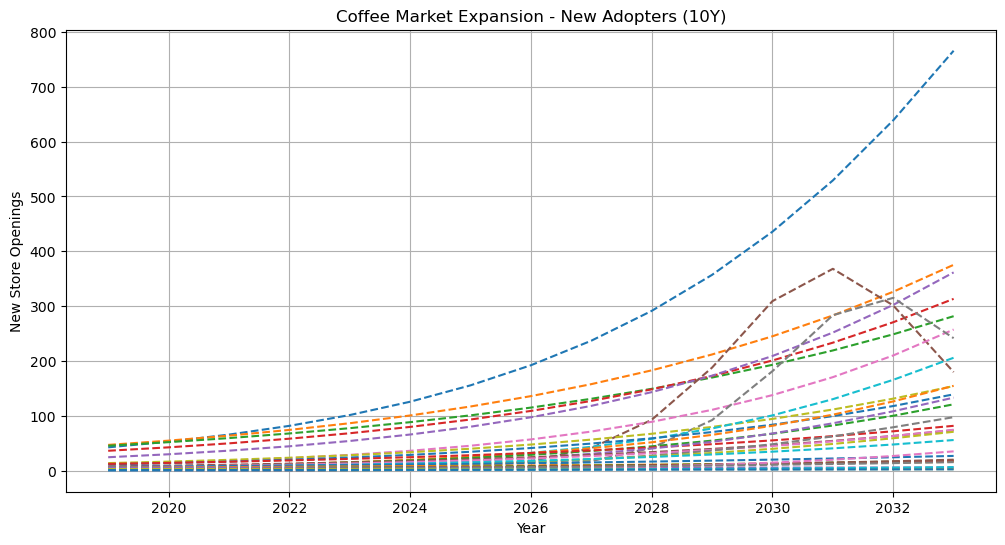

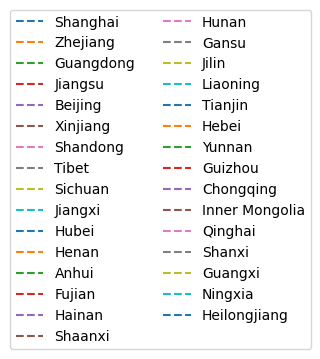

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from xgboost import XGBRegressor

# -----------------------------------------
# üìå ËÆ°ÁÆóË¥≠‰π∞È¢ëÁéá F
# -----------------------------------------
def calculate_F():
    probabilities = [0.016, 0.10, 0.079, 0.156, 0.434, 0.215]
    consumption = [0, 2, 2.5, 4, 10, 30]
    return sum(p * c for p, c in zip(probabilities, consumption))

F_value = calculate_F()

# -----------------------------------------
# üìå Bass Diffusion Model with Frequency (F)
# -----------------------------------------
def bass_model_with_F(t, p, q, M, F):
    """BassÊâ©Êï£Ê®°Âûã + Ë¥≠‰π∞È¢ëÁéá F"""
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t)) * F

# -----------------------------------------
# üìå ËØªÂèñÊï∞ÊçÆ
# -----------------------------------------
df_market = pd.read_csv("Estimated_M.csv")
area_m_values = dict(zip(df_market["Area"], df_market["M_Predicted"]))

df = pd.read_excel("Bass_Diffusion_Cleaned_Final.xlsx")

# -----------------------------------------
# üìå ÂèÇÊï∞ËÆæÁΩÆ
# -----------------------------------------
target = "New_Stores"
future_years = 10
past_years = 10
results = []
line_mapping = {}  # Âå∫ÂüüÂØπÂ∫îÁöÑ Line ÂØπË±°

# -----------------------------------------
# üìå ÈÅçÂéÜÊâÄÊúâÂå∫Âüü
# -----------------------------------------
for area in df["Area"].unique():
    area_data = df[df["Area"] == area].sort_values(by="Year", ascending=True)

    if len(area_data) < 3:
        print(f"Skipping {area} due to insufficient data points (< 3)")
        continue

    years = area_data["Year"].values
    y = area_data[target].values
    adopters = np.cumsum(y)
    new_adopters = np.diff(adopters, prepend=0)

    market_size = area_m_values.get(area, 2500)

    # XGBoostÈ¢ÑÊµãÂéÜÂè≤
    past_years_range = np.arange(years.min() - past_years, years.min())
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    xgb_model.fit(years.reshape(-1, 1), adopters)
    past_predictions = xgb_model.predict(past_years_range.reshape(-1, 1))
    past_new_adopters = np.diff(past_predictions, prepend=0)

    all_years = np.concatenate([past_years_range, years])
    all_adopters = np.concatenate([past_predictions, adopters])

    try:
        popt, _ = curve_fit(lambda t, p, q: bass_model_with_F(t, p, q, market_size, F_value),
                            xdata=(all_years - all_years.min()),
                            ydata=all_adopters,
                            p0=(0.01, 0.3),
                            bounds=(0, [1, 0.9]))
        p_base, q_base = popt
    except RuntimeError:
        print(f"Warning: Could not fit Bass model for {area}")
        continue

    future_years_range = np.arange(years.min(), years.max() + future_years + 1)
    future_predictions = bass_model_with_F(future_years_range - all_years.min(), p_base, q_base, market_size, F_value)
    future_new_adopters = np.diff(future_predictions, prepend=0)

    final_adoption = future_predictions[-1]

    # Â≠òÂÇ®ÁªìÊûú
    results.append((area, past_years_range, past_new_adopters, future_years_range,
                    future_new_adopters, years, new_adopters, final_adoption))

# -------------------------------
# üìå ÊåâÊúÄÁªàÂ∏ÇÂú∫ËßÑÊ®°ÊéíÂ∫è
# -------------------------------
results.sort(key=lambda x: x[-1], reverse=True)


# -------------------------------
# üìå ÁªòÂà∂ÂõæÂÉèÔºàÊñ∞Â¢ûÂºÄÂ∫óÊï∞Ôºâ
# -------------------------------
fig, ax = plt.subplots(figsize=(12, 6))
handles = []
labels = []

for area, past_years_range, past_new_adopters, future_years_range, future_new_adopters, years, new_adopters, final_adoption in results:

    line, = ax.plot(future_years_range[1:], future_new_adopters[1:], linestyle="--")
    handles.append(line)
    labels.append(f"{area}")

plt.xlabel("Year")
plt.ylabel("New Store Openings")
plt.title("Coffee Market Expansion - New Adopters (10Y)")
plt.grid(True)

# -------------------------------
# üìå ÂàõÂª∫Âõæ‰æã
# -------------------------------
fig_legend, ax_legend = plt.subplots(figsize=(2,4))  # Ë∞ÉÊï¥Âõæ‰æãÂ§ßÂ∞è
ax_legend.axis("off")  # ÁßªÈô§ÂùêÊ†áËΩ¥
legend = ax_legend.legend(handles, labels, loc="center", fontsize=10, ncol=2)  # Â±Ö‰∏≠Âõæ‰æãÔºå2 Âàó
fig_legend.canvas.draw()

plt.show()

In [79]:
import numpy as np
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

def bass_model_with_F(t, p, q, M, F):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t)) * F

r2_scores = []

for area_data in results:
    area, past_years_range, past_new_adopters, future_years_range, future_new_adopters, years, new_adopters, final_adoption = area_data

    M = area_m_values.get(area, 2500)
    F = F_value

    # Time series (relative to first year)
    all_years = np.concatenate([past_years_range, years])
    t = all_years - all_years.min()
    
    # True cumulative adopters
    y_true = np.concatenate([past_new_adopters, new_adopters]).cumsum()

    try:
        # Fit Bass model
        popt, _ = curve_fit(lambda t, p, q: bass_model_with_F(t, p, q, M, F),
                            xdata=t,
                            ydata=y_true,
                            p0=(0.01, 0.3),
                            bounds=(0, [1, 0.9]))
        p, q = popt

        # Predict
        y_pred = bass_model_with_F(t, p, q, M, F)

        # Compute R¬≤
        r2 = r2_score(y_true, y_pred)
        r2_scores.append(r2)
        print(f"R¬≤ for {area}: {r2:.4f}")

    except RuntimeError:
        print(f"‚ö†Ô∏è Could not fit Bass model for {area}")
        continue

# Average R¬≤
if r2_scores:
    average_r2 = np.mean(r2_scores)
    print(f"\n‚úÖ Average R¬≤ across all areas: {average_r2:.4f}")
else:
    print("‚ùå No R¬≤ values computed.")


R¬≤ for Shanghai: 0.9127
R¬≤ for Zhejiang: 0.8783
R¬≤ for Guangdong: 0.8641
R¬≤ for Jiangsu: 0.8827
R¬≤ for Beijing: 0.9018
R¬≤ for Xinjiang: 0.9627
R¬≤ for Shandong: 0.9113
R¬≤ for Tibet: 0.8236
R¬≤ for Sichuan: 0.8913
R¬≤ for Jiangxi: 0.9537
R¬≤ for Hubei: 0.8957
R¬≤ for Henan: 0.9233
R¬≤ for Anhui: 0.9117
R¬≤ for Fujian: 0.8637
R¬≤ for Hainan: 0.9428
R¬≤ for Shaanxi: 0.8752
R¬≤ for Hunan: 0.8974
R¬≤ for Gansu: 0.9560
R¬≤ for Jilin: 0.9246
R¬≤ for Liaoning: 0.8843
R¬≤ for Tianjin: 0.8398
R¬≤ for Hebei: 0.8175
R¬≤ for Yunnan: 0.8539
R¬≤ for Guizhou: 0.8503
R¬≤ for Chongqing: 0.7660
R¬≤ for Inner Mongolia: 0.8750
R¬≤ for Qinghai: 0.9184
R¬≤ for Shanxi: 0.8632
R¬≤ for Guangxi: 0.7626
R¬≤ for Ningxia: 0.8824
R¬≤ for Heilongjiang: 0.7784

‚úÖ Average R¬≤ across all areas: 0.8795


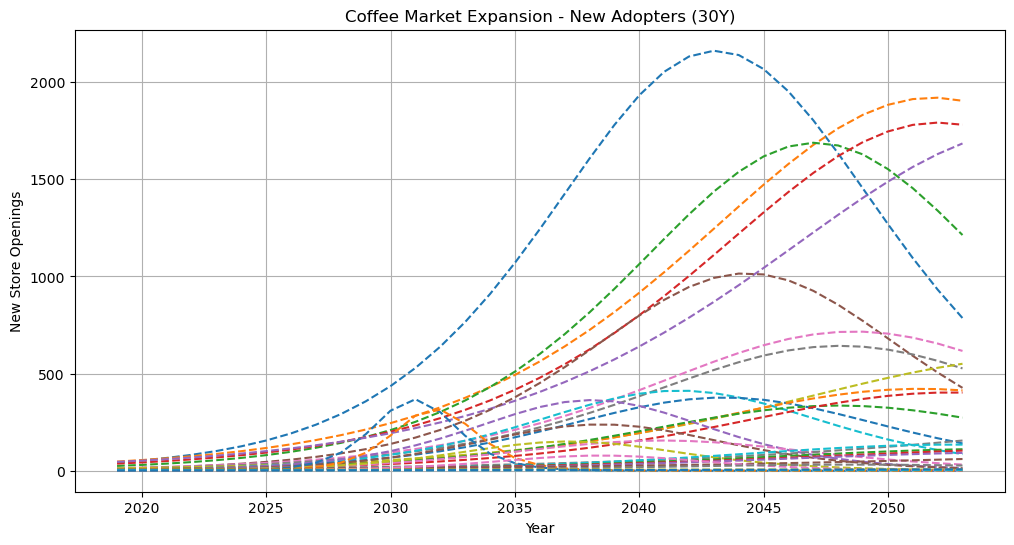

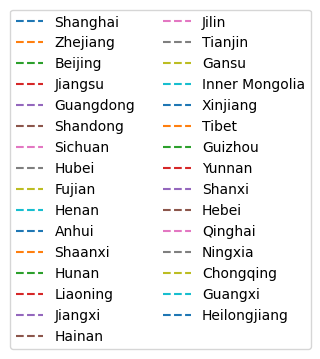

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from xgboost import XGBRegressor


# -------------------------------
# üìå ËÆ°ÁÆóË¥≠‰π∞È¢ëÁéá F
# -------------------------------
def calculate_F():
    probabilities = [0.016, 0.10, 0.079, 0.156, 0.434, 0.215]
    consumption = [0, 2, 2.5, 4, 10, 30]
    return sum(p * c for p, c in zip(probabilities, consumption))


F_value = calculate_F()


# -------------------------------
# üìå Bass Diffusion Model with Frequency (F)
# -------------------------------
def bass_model_with_F(t, p, q, M, F):
    """BassÊâ©Êï£Ê®°Âûã + Ë¥≠‰π∞È¢ëÁéá F"""
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t)) * F


# -------------------------------
# üìå ËØªÂèñÂ∏ÇÂú∫ÊΩúÂäõÊï∞ÊçÆ
# -------------------------------
file_path = "Estimated_M.csv"
df_market = pd.read_csv(file_path)
area_m_values = dict(zip(df_market["Area"], df_market["M_Predicted"]))


# -------------------------------
# üìå ËØªÂèñ Bass Diffusion Êï∞ÊçÆ
# -------------------------------
df = pd.read_excel("Bass_Diffusion_Cleaned_Final.xlsx")


# -------------------------------
# üìå Ê®°ÂûãÂèÇÊï∞
# -------------------------------
target = "New_Stores"
future_years = 30
past_years = 10
results = []


# -------------------------------
# üìå ÈÅçÂéÜÊâÄÊúâÂå∫Âüü
# -------------------------------
for area in df["Area"].unique():
    area_data = df[df["Area"] == area].sort_values(by="Year", ascending=True)

    if len(area_data) < 3:
        print(f"Skipping {area} due to insufficient data points (< 3)")
        continue

    years = area_data["Year"].values
    y = area_data[target].values
    adopters = np.cumsum(y)  # üìå ËÆ°ÁÆóÁ¥ØËÆ°ÂºÄÂ∫óÊï∞
    new_adopters = np.diff(adopters, prepend=0)  # üìå ËÆ°ÁÆóÊØèÂπ¥ÁöÑÊñ∞Â¢ûÂºÄÂ∫óÊï∞

    # üìå ËØªÂèñÂ∏ÇÂú∫ÊΩúÂäõ M
    market_size = area_m_values.get(area, 2500)

    # üìå ËÆ≠ÁªÉ XGBoost È¢ÑÊµãËøáÂéª 10 Âπ¥Êï∞ÊçÆ
    past_years_range = np.arange(years.min() - past_years, years.min())
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    xgb_model.fit(years.reshape(-1, 1), adopters)
    past_predictions = xgb_model.predict(past_years_range.reshape(-1, 1))

    # üìå ËÆ°ÁÆó XGBoost È¢ÑÊµãÁöÑÊñ∞Â¢ûÂºÄÂ∫óÊï∞
    past_new_adopters = np.diff(past_predictions, prepend=0)

    # üìå ÂêàÂπ∂ÂéÜÂè≤Êï∞ÊçÆ
    all_years = np.concatenate([past_years_range, years])
    all_adopters = np.concatenate([past_predictions, adopters])

    # üìå ÊãüÂêà Bass Ê®°Âûã
    try:
        popt, _ = curve_fit(lambda t, p, q: bass_model_with_F(t, p, q, market_size, F_value),
                            xdata=(all_years - all_years.min()),
                            ydata=all_adopters,
                            p0=(0.01, 0.3),
                            bounds=(0, [1, 0.9]))
        p_base, q_base = popt
    except RuntimeError:
        print(f"Warning: Could not fit Bass model for {area}")
        continue

    # üìå È¢ÑÊµãÊú™Êù• 50 Âπ¥
    future_years_range = np.arange(years.min(), years.max() + future_years + 1)
    future_predictions = bass_model_with_F(future_years_range - all_years.min(), p_base, q_base, market_size, F_value)

    # üìå ËÆ°ÁÆóÊú™Êù•ÁöÑÊñ∞Â¢ûÂºÄÂ∫óÊï∞
    future_new_adopters = np.diff(future_predictions, prepend=0)

    # üìå Â≠òÂÇ®ÁªìÊûú
    final_adoption = future_predictions[-1]
    results.append((area, past_years_range, past_new_adopters, future_years_range, future_new_adopters, years, new_adopters, final_adoption))


# -------------------------------
# üìå ÊåâÊúÄÁªàÂ∏ÇÂú∫ËßÑÊ®°ÊéíÂ∫è
# -------------------------------
results.sort(key=lambda x: x[-1], reverse=True)


# -------------------------------
# üìå ÁªòÂà∂ÂõæÂÉèÔºàÊñ∞Â¢ûÂºÄÂ∫óÊï∞Ôºâ
# -------------------------------
fig, ax = plt.subplots(figsize=(12, 6))
handles = []
labels = []

for area, past_years_range, past_new_adopters, future_years_range, future_new_adopters, years, new_adopters, final_adoption in results:

    line, = ax.plot(future_years_range[1:], future_new_adopters[1:], linestyle="--")
    handles.append(line)
    labels.append(f"{area}")

plt.xlabel("Year")
plt.ylabel("New Store Openings")
plt.title("Coffee Market Expansion - New Adopters (30Y)")
plt.grid(True)

# -------------------------------
# üìå ÂàõÂª∫Âõæ‰æã
# -------------------------------
fig_legend, ax_legend = plt.subplots(figsize=(2,4))  # Ë∞ÉÊï¥Âõæ‰æãÂ§ßÂ∞è
ax_legend.axis("off")  # ÁßªÈô§ÂùêÊ†áËΩ¥
legend = ax_legend.legend(handles, labels, loc="center", fontsize=10, ncol=2)  # Â±Ö‰∏≠Âõæ‰æãÔºå2 Âàó
fig_legend.canvas.draw()

plt.show()

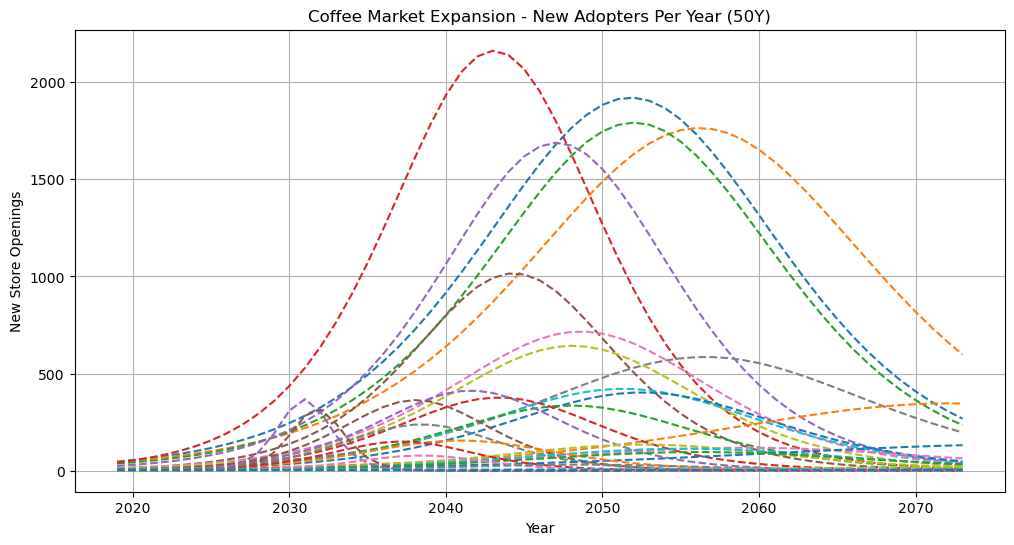

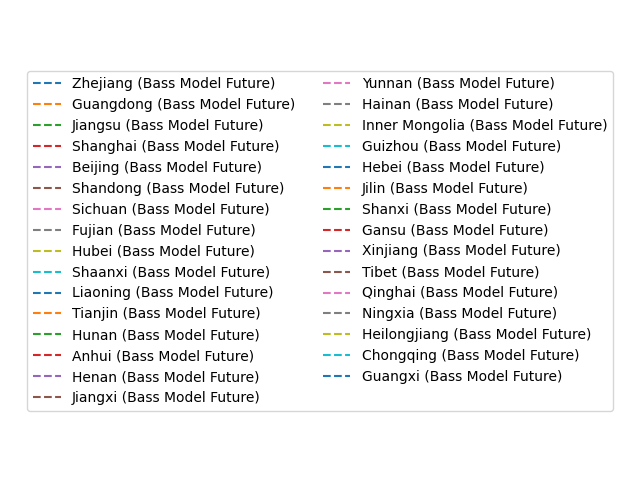

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from xgboost import XGBRegressor


# -------------------------------
# üìå ËÆ°ÁÆóË¥≠‰π∞È¢ëÁéá F
# -------------------------------
def calculate_F():
    probabilities = [0.016, 0.10, 0.079, 0.156, 0.434, 0.215]
    consumption = [0, 2, 2.5, 4, 10, 30]
    return sum(p * c for p, c in zip(probabilities, consumption))


F_value = calculate_F()


# -------------------------------
# üìå Bass Diffusion Model with Frequency (F)
# -------------------------------
def bass_model_with_F(t, p, q, M, F):
    """BassÊâ©Êï£Ê®°Âûã + Ë¥≠‰π∞È¢ëÁéá F"""
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t)) * F


# -------------------------------
# üìå ËØªÂèñÂ∏ÇÂú∫ÊΩúÂäõÊï∞ÊçÆ
# -------------------------------
file_path = "Estimated_M.csv"
df_market = pd.read_csv(file_path)
area_m_values = dict(zip(df_market["Area"], df_market["M_Predicted"]))


# -------------------------------
# üìå ËØªÂèñ Bass Diffusion Êï∞ÊçÆ
# -------------------------------
df = pd.read_excel("Bass_Diffusion_Cleaned_Final.xlsx")


# -------------------------------
# üìå Ê®°ÂûãÂèÇÊï∞
# -------------------------------
target = "New_Stores"
future_years = 50
past_years = 10
results = []


# -------------------------------
# üìå ÈÅçÂéÜÊâÄÊúâÂå∫Âüü
# -------------------------------
for area in df["Area"].unique():
    area_data = df[df["Area"] == area].sort_values(by="Year", ascending=True)

    if len(area_data) < 3:
        print(f"Skipping {area} due to insufficient data points (< 3)")
        continue

    years = area_data["Year"].values
    y = area_data[target].values
    adopters = np.cumsum(y)  # üìå ËÆ°ÁÆóÁ¥ØËÆ°ÂºÄÂ∫óÊï∞
    new_adopters = np.diff(adopters, prepend=0)  # üìå ËÆ°ÁÆóÊØèÂπ¥ÁöÑÊñ∞Â¢ûÂºÄÂ∫óÊï∞

    # üìå ËØªÂèñÂ∏ÇÂú∫ÊΩúÂäõ M
    market_size = area_m_values.get(area, 2500)

    # üìå ËÆ≠ÁªÉ XGBoost È¢ÑÊµãËøáÂéª 10 Âπ¥Êï∞ÊçÆ
    past_years_range = np.arange(years.min() - past_years, years.min())
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    xgb_model.fit(years.reshape(-1, 1), adopters)
    past_predictions = xgb_model.predict(past_years_range.reshape(-1, 1))

    # üìå ËÆ°ÁÆó XGBoost È¢ÑÊµãÁöÑÊñ∞Â¢ûÂºÄÂ∫óÊï∞
    past_new_adopters = np.diff(past_predictions, prepend=0)

    # üìå ÂêàÂπ∂ÂéÜÂè≤Êï∞ÊçÆ
    all_years = np.concatenate([past_years_range, years])
    all_adopters = np.concatenate([past_predictions, adopters])

    # üìå ÊãüÂêà Bass Ê®°Âûã
    try:
        popt, _ = curve_fit(lambda t, p, q: bass_model_with_F(t, p, q, market_size, F_value),
                            xdata=(all_years - all_years.min()),
                            ydata=all_adopters,
                            p0=(0.01, 0.3),
                            bounds=(0, [1, 0.9]))
        p_base, q_base = popt
    except RuntimeError:
        print(f"Warning: Could not fit Bass model for {area}")
        continue

    # üìå È¢ÑÊµãÊú™Êù• 50 Âπ¥
    future_years_range = np.arange(years.min(), years.max() + future_years + 1)
    future_predictions = bass_model_with_F(future_years_range - all_years.min(), p_base, q_base, market_size, F_value)

    # üìå ËÆ°ÁÆóÊú™Êù•ÁöÑÊñ∞Â¢ûÂºÄÂ∫óÊï∞
    future_new_adopters = np.diff(future_predictions, prepend=0)

    # üìå Â≠òÂÇ®ÁªìÊûú
    final_adoption = future_predictions[-1]
    results.append((area, past_years_range, past_new_adopters, future_years_range, future_new_adopters, years, new_adopters, final_adoption))


# -------------------------------
# üìå ÊåâÊúÄÁªàÂ∏ÇÂú∫ËßÑÊ®°ÊéíÂ∫è
# -------------------------------
results.sort(key=lambda x: x[-1], reverse=True)


# -------------------------------
# üìå ÁªòÂà∂ÂõæÂÉèÔºàÊñ∞Â¢ûÂºÄÂ∫óÊï∞Ôºâ
# -------------------------------
fig, ax = plt.subplots(figsize=(12, 6))
handles = []
labels = []

for area, past_years_range, past_new_adopters, future_years_range, future_new_adopters, years, new_adopters, final_adoption in results:

    line, = ax.plot(future_years_range[1:], future_new_adopters[1:], linestyle="--")
    handles.append(line)
    labels.append(f"{area} (Bass Model Future)")

plt.xlabel("Year")
plt.ylabel("New Store Openings")
plt.title("Coffee Market Expansion - New Adopters Per Year (50Y)")
plt.grid(True)

# -------------------------------
# üìå ÂàõÂª∫Âõæ‰æã
# -------------------------------
fig_legend, ax_legend = plt.subplots(figsize=(8, 6))  # Ë∞ÉÊï¥Âõæ‰æãÂ§ßÂ∞è
ax_legend.axis("off")  # ÁßªÈô§ÂùêÊ†áËΩ¥
legend = ax_legend.legend(handles, labels, loc="center", fontsize=10, ncol=2)  # Â±Ö‰∏≠Âõæ‰æãÔºå2 Âàó
fig_legend.canvas.draw()

plt.show()